In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [4]:

encodings = ['utf-8', 'latin1', 'cp1252']
df = None
for enc in encodings:
    try:
        df = pd.read_csv("data.csv", encoding=enc)
        print(f"Loaded with encoding {enc}, shape={df.shape}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")

df.head()


Failed with utf-8: 'utf-8' codec can't decode byte 0xa3 in position 28: invalid start byte
Loaded with encoding latin1, shape=(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

df = df[df['Quantity'] > 0]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:

reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [7]:

rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])

X = rfm[['Recency', 'Frequency_log', 'Monetary_log']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Best k = 3


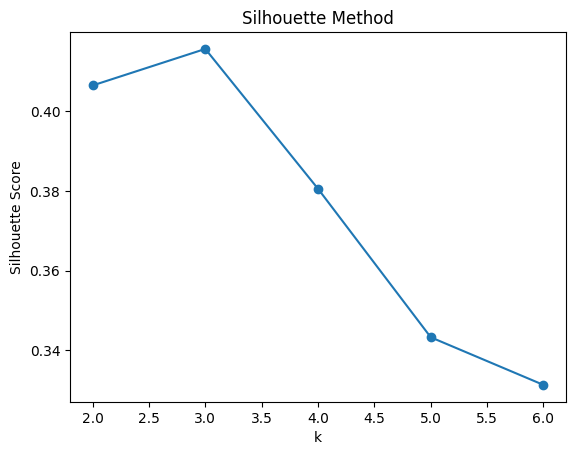

In [13]:

sil_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

best_k = max(sil_scores, key=sil_scores.get)
print("Best k =", best_k)
plt.savefig("Silhouette.png", dpi=300, bbox_inches="tight")
plt.show()




In [9]:

final_km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
rfm['Cluster'] = final_km.fit_predict(X_scaled)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,Monetary_log,Frequency_log,Cluster
0,12346,326,1,77183.60,11.253955,0.693147,1
1,12347,2,7,4310.00,8.368925,2.079442,1
2,12348,75,4,1797.24,7.494564,1.609438,1
3,12349,19,1,1757.55,7.472245,0.693147,0
4,12350,310,1,334.40,5.815324,0.693147,2


In [10]:

cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(2)

cluster_profile


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,54.86,2.05,615.24,2036
1,30.10,9.83,5494.34,1323
2,255.27,1.39,398.13,979


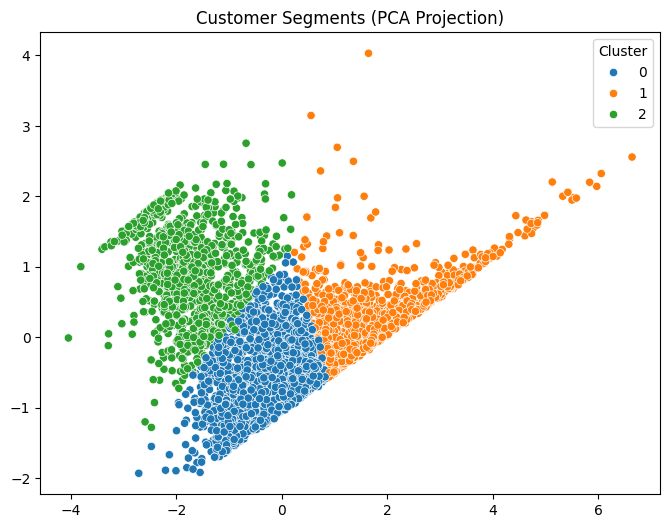

In [14]:

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],
                hue=rfm['Cluster'], palette='tab10')
plt.title("Customer Segments (PCA Projection)")

plt.savefig("Segment.png", dpi=300, bbox_inches="tight")
plt.show()



In [15]:

rfm.to_csv("After Clustering.csv", index=False)
print("Results saved as customer_segments.csv")


Results saved as customer_segments.csv
